In [2]:
# ERROR: Could not build wheels for prophet, which is required to install pyproject.toml-based projects
# https://stackoverflow.com/a/76476415
!py -m pip install mariadb pyyaml prophet

### Standard references

In [4]:
from datetime import datetime, timedelta
from typing import Any, Dict, List, Sequence, Tuple
from yaml import safe_load
from logging import INFO, Formatter, basicConfig, warning, getLogger
from mariadb import Connection, Cursor

import re

### namespace: `utils`

In [6]:
DATETIME_FORMAT: str = "%Y-%m-%d %H:%M:%S"
TIMEZONE_DIFFERENCE: Dict[str, int] = {"hours": -3, "minutes": 0}

def number_of_days_between(start_period: datetime, final_period: datetime) -> int:
    difference: timedelta = final_period - start_period
    return difference.days

def brt_now() -> datetime:
    return datetime.utcnow() + timedelta(**TIMEZONE_DIFFERENCE)

class Settings(object):
    CONFIG: Dict[str, Any] = {}

    def __init__(self, *args: Tuple[Any, ...], **kwargs: Dict[str, Any]):
        raise SyntaxError("This is an utility class.")

    @staticmethod
    def load(path: str) -> None:
        with open(path, "r") as file:
            Settings.CONFIG = safe_load(file)

### namespace: `db`

In [8]:
class Report(object):
    def __init__(
        self,
        subsystem_id: str,
        instant_record: datetime | str,
        instant_load_following: float,
    ):
        self.__subsystem_id: str = subsystem_id
        self.__instant_record: datetime = datetime.min

        if isinstance(instant_record, datetime):
            self.__instant_record = instant_record
        else:
            try:
                self.__instant_record = datetime.strptime(
                    instant_record, DATETIME_FORMAT
                )
            except ValueError:
                self.__instant_record = datetime.strptime(
                    f"{instant_record} 00:00:00", DATETIME_FORMAT
                )

        self.__instant_load_following: float = instant_load_following

    @property
    def subsystem_id(self) -> str:
        return self.__subsystem_id

    @subsystem_id.setter
    def subsystem_id(self, value: str) -> None:
        self.__subsystem_id = value

    @property
    def instant_record(self) -> datetime:
        return self.__instant_record

    @instant_record.setter
    def instant_record(self, value: datetime) -> None:
        self.__instant_record = value

    @property
    def instant_load_following(self) -> float:
        return self.__instant_load_following

    @instant_load_following.setter
    def instant_load_following(self, value: float) -> None:
        self.__instant_load_following = value

    def serialize_data(self) -> Tuple[str, datetime, float]:
        return (
            self.__subsystem_id,
            self.__instant_record,
            self.__instant_load_following,
        )

    def to_json(self) -> Dict[str, Any]:
        return {
            "subsystem_id": self.__subsystem_id,
            "instant_record": self.__instant_record.strftime(DATETIME_FORMAT),
            "instant_load_following": self.__instant_load_following,
        }


class MariaDbUtils(object):
    def __init__(self, *args: Tuple[Any, ...]):
        raise SyntaxError("This is an utility class.")

    @staticmethod
    def add_report(report: Report) -> bool:
        with MariaDb() as mariadb:
            return mariadb.execute(
                query="""
                INSERT INTO `sin_subsystems_reports` (
                    `subsystem_id`, `instant_record`,
                    `instant_load_following`
                ) VALUES (?, ?, ?)
                """,
                data=report.serialize_data(),
            )

    @staticmethod
    def add_reports(reports: List[Report]) -> bool:
        with MariaDb() as mariadb:
            return mariadb.executemany(
                query="""
                INSERT INTO `sin_subsystems_reports` (
                    `subsystem_id`, `instant_record`,
                    `instant_load_following`
                ) VALUES (?, ?, ?)
                """,
                data=[report.serialize_data() for report in reports],
            )

    @staticmethod
    def is_empty_reports() -> bool:
        with MariaDb() as mariadb:
            cursor: Cursor = mariadb.execute(
                query="SELECT COUNT(`id`) FROM `sin_subsystems_reports`"
            )
            cursor_results: Tuple[int, ...] = cursor.fetchone()
            (count_reports,) = cursor_results
            return count_reports == 0
        
    @staticmethod
    def fetch_subsystem_name_by_id(subsystem_id: str) -> str:
        with MariaDb() as mariadb:
            cursor: Cursor = mariadb.execute(
                query="SELECT `name` FROM `sin_subsystems` WHERE `id`=?",
                data=(subsystem_id,),
            )
            cursor_results: Tuple[str, ...] = cursor.fetchone()
            if cursor_results.__len__() == 0:
                return None
            
            (subsystem_name,) = cursor_results
            return subsystem_name

    @staticmethod
    def fetch_reports_by_subsystem_id(subsystem_id: str) -> List[Report]:
        with MariaDb() as mariadb:
            cursor: Cursor = mariadb.execute(
                query="SELECT * FROM `sin_subsystems_reports` WHERE `subsystem_id`=?",
                data=(subsystem_id,),
            )
            for args in cursor:
                yield Report(*args[1:])

    @staticmethod
    def fetch_distinct_instant_record_years() -> List[int]:
        if MariaDbUtils.is_empty_reports():
            yield None

        with MariaDb() as mariadb:
            current_year: int = brt_now().year
            cursor: Cursor = mariadb.execute(
                query="SELECT DISTINCT YEAR(`instant_record`) FROM `sin_subsystems_reports`"
            )
            for (year,) in cursor:
                if year < current_year:
                    yield year

    @staticmethod
    def fetch_latest_instant_record() -> datetime:
        if MariaDbUtils.is_empty_reports():
            return datetime.min

        with MariaDb() as mariadb:
            cursor: Cursor = mariadb.execute(
                query="SELECT MAX(`instant_record`) FROM `sin_subsystems_reports`"
            )
            cursor_results: Tuple[datetime, ...] = cursor.fetchone()
            if cursor_results.__len__() == 0:
                return datetime.min

            (instant_record,) = cursor_results
            return instant_record


class MariaDb(object):
    def __init__(self):
        self.__db_connection: Connection = None

    def __enter__(self):
        try:
            self.__db_connection: Connection = Connection(**Settings.CONFIG["database"])
        except Exception as err:
            warning(f"Error connecting to MariaDB Platform: {err}", RuntimeWarning)
        return self

    def __exit__(self, *args: Tuple[Any, ...]) -> None:
        self.__db_connection.close()

    def execute(self, query: str, data: Sequence = ()) -> Cursor | bool:
        is_select_statement: bool = bool(re.match(r"^(select).*", query.lower()))
        db_cursor: Cursor = self.__db_connection.cursor()
        try:
            db_cursor.execute(query.strip(), data)
            if is_select_statement:
                return db_cursor
            else:
                return True
        except Exception as err:
            warning(
                f"Error while committing changes to database: {err}", RuntimeWarning
            )
            return False

    def executemany(self, query: str, data: List[Sequence]) -> bool:
        db_cursor: Cursor = self.__db_connection.cursor()
        try:
            db_cursor.executemany(query.strip(), data)
            return True
        except Exception as err:
            warning(
                f"Error while committing massive changes to database: {err}",
                RuntimeWarning,
            )
            return False

### namespace: `__init__::__main__()`

In [10]:
Settings.load("../settings.yaml")

log_fmt: Formatter = Formatter(
    "%(asctime)s,%(msecs)-3d - %(levelname)-8s => " "%(message)s"
)
log_config: Dict[str, Any] = {
    "format": vars(log_fmt).get("_fmt"),
    "datefmt": "%Y-%m-%d %H:%M:%S"
}
basicConfig(**log_config)
getLogger().setLevel(INFO)

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import pandas as pd

# https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
%matplotlib inline
plt.style.use('fivethirtyeight')

In [18]:
SUBSYSTEM_ID: str = "N" # searching for  'North' subsystem on SIN
SUBSYSTEM_NAME: str = MariaDbUtils.fetch_subsystem_name_by_id(SUBSYSTEM_ID)

In [20]:
reports_by_subsystem_id: List[Report] = list(MariaDbUtils.fetch_reports_by_subsystem_id(SUBSYSTEM_ID))

In [22]:
reports_by_subsystem_id.__len__()

9150

In [24]:
df: pd.DataFrame = pd.DataFrame(
    [report.serialize_data() for report in reports_by_subsystem_id],
    columns=['subsystem_id', 'instant_record', 'instant_load_following']
)

In [26]:
df.head()

,subsystem_id,instant_record,instant_load_following
0,N,2000-01-01,2243.51
1,N,2000-01-02,2259.81
2,N,2000-01-03,2407.43
3,N,2000-01-04,2404.22
4,N,2000-01-05,2439.65


In [27]:
all_years: List[int] = df['instant_record'].dt.year.unique()
first_instant_record: datetime = df['instant_record'].iloc[0]
last_instant_record: datetime = df['instant_record'].iloc[-1]

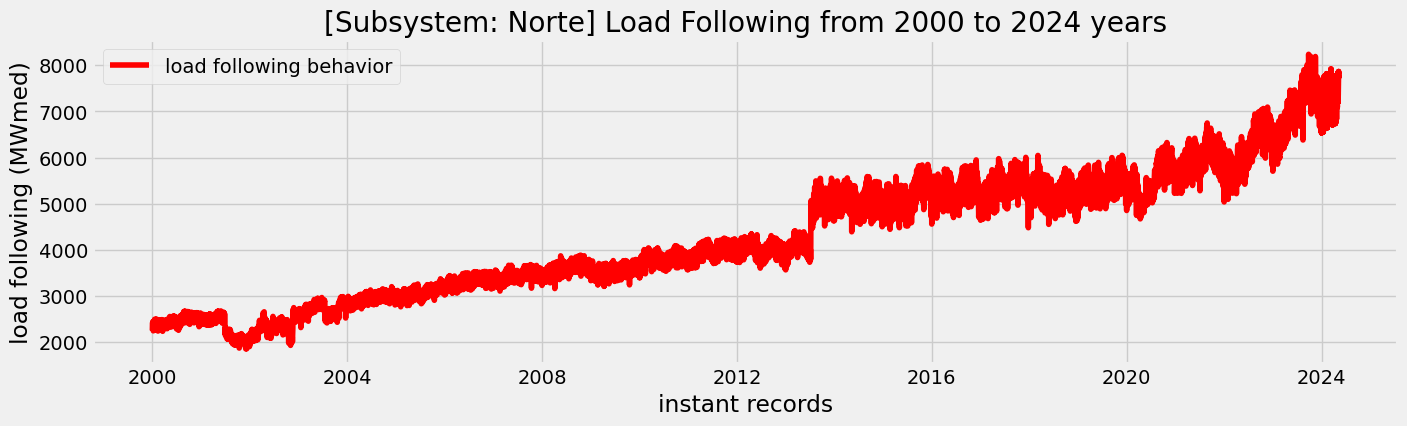

In [28]:
plt.figure(figsize=(15,4), dpi=100)
plt.plot(df['instant_record'], df['instant_load_following'], color='r', label='load following behavior')
plt.gca().set(
    title=f'[Subsystem: {SUBSYSTEM_NAME}] Load Following from {all_years[0]} to {all_years[-1]} years',
    xlabel="instant records",
    ylabel="load following (MWmed)"
)
plt.legend()
plt.show()

In [32]:
total_period: timedelta = last_instant_record.year - first_instant_record.year
total_period

24

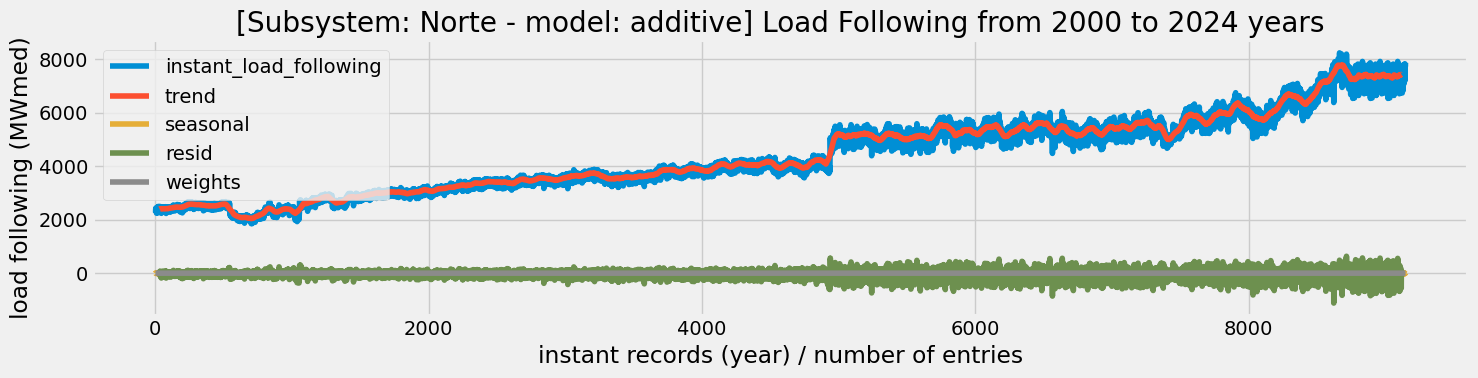

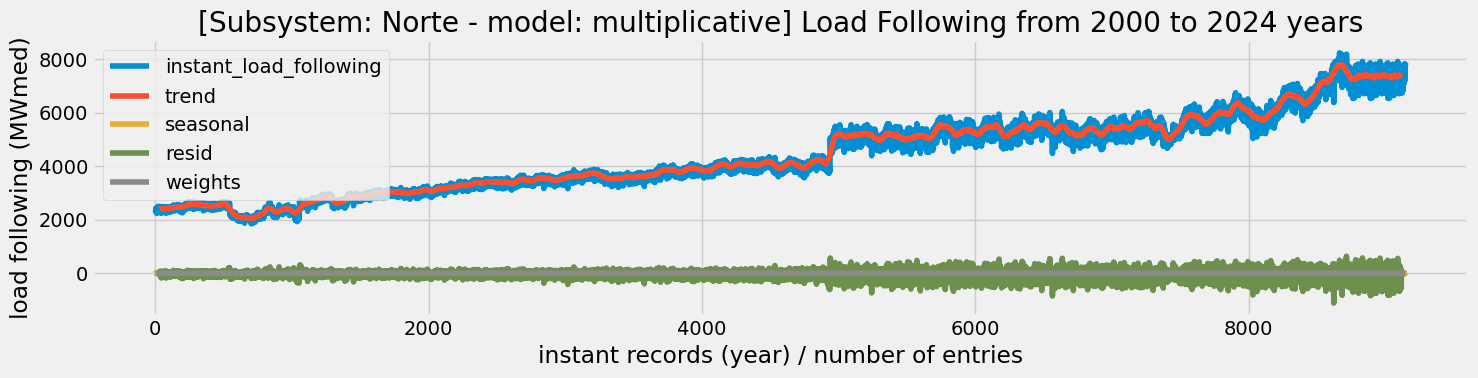

In [34]:
for decomposition_model in ['additive', 'multiplicative']:
    plt.figure(figsize=(15,4), dpi=100)
    
    decomposition = seasonal_decompose(df['instant_load_following'], model='decomposition_model', period=60)

    plt.title(f'[Subsystem: {SUBSYSTEM_NAME} - model: {decomposition_model}] Load Following from {all_years[0]} to {all_years[-1]} years')
    plt.xlabel("instant records (year) / number of entries")
    plt.ylabel("load following (MWmed)")

    decomposition.observed.plot(legend=True)
    decomposition.trend.plot(legend=True)
    decomposition.seasonal.plot(legend=True)
    decomposition.resid.plot(legend=True)
    decomposition.weights.plot(legend=True)

    plt.tight_layout()
    
plt.show()

In [36]:
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation
from warnings import simplefilter

# Diagnostics | Prophet
# https://facebook.github.io/prophet/docs/diagnostics.html

# DatetimeProperties.to_pydatetime is deprecated:
# https://community.plotly.com/t/datetimeproperties-to-pydatetime-is-deprecated/78293/4
simplefilter("ignore", FutureWarning)

In [38]:
forecasting_model: Prophet = Prophet(interval_width=0.95)

2024-05-14 18:45:54,908 - DEBUG    => cmd: where.exe tbb.dll
cwd: None
2024-05-14 18:45:54,965 - DEBUG    => Adding TBB (C:\Users\nadio\anaconda3\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9150 entries, 0 to 9149
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   subsystem_id            9150 non-null   object        
 1   instant_record          9150 non-null   datetime64[ns]
 2   instant_load_following  9150 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 214.6+ KB


In [42]:
formatted_df: pd.DataFrame = df.drop(columns=['subsystem_id'])\
    .rename(columns={
        'instant_record': 'ds',
        'instant_load_following': 'y'
    })

In [44]:
formatted_df.head()

,ds,y
0,2000-01-01,2243.51
1,2000-01-02,2259.81
2,2000-01-03,2407.43
3,2000-01-04,2404.22
4,2000-01-05,2439.65


In [46]:
forecasting_model.fit(formatted_df)

2024-05-14 18:45:58,963 - INFO     => Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-05-14 18:45:59,83  - DEBUG    => input tempfile: C:\Users\nadio\AppData\Local\Temp\tmp3cxp7iaz\1ub3jy38.json
2024-05-14 18:45:59,588 - DEBUG    => input tempfile: C:\Users\nadio\AppData\Local\Temp\tmp3cxp7iaz\5m_8xj5z.json
2024-05-14 18:45:59,590 - DEBUG    => idx 0
2024-05-14 18:45:59,592 - DEBUG    => running CmdStan, num_threads: None
2024-05-14 18:45:59,592 - DEBUG    => CmdStan args: ['C:\\Users\\nadio\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=66879', 'data', 'file=C:\\Users\\nadio\\AppData\\Local\\Temp\\tmp3cxp7iaz\\1ub3jy38.json', 'init=C:\\Users\\nadio\\AppData\\Local\\Temp\\tmp3cxp7iaz\\5m_8xj5z.json', 'output', 'file=C:\\Users\\nadio\\AppData\\Local\\Temp\\tmp3cxp7iaz\\prophet_modell4457y7i\\prophet_model-20240514184559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:59 - cmdstanpy - IN

In [47]:
# Offset aliases
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
future_instant_records: pd.DataFrame = forecasting_model.make_future_dataframe(
    periods=number_of_days_between(
        start_period=datetime.now(),
        final_period=datetime(2030, 12, 31)
    ),
    freq='D'
)
future_instant_records.tail()

,ds
11308,2030-12-20
11309,2030-12-21
11310,2030-12-22
11311,2030-12-23
11312,2030-12-24


In [48]:
forecast: pd.DataFrame = forecasting_model.predict(future_instant_records)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
11308,2030-12-20,10844.916797,4319.503457,18073.996425
11309,2030-12-21,10681.677942,4104.060732,17721.324108
11310,2030-12-22,10489.669165,3901.645135,17713.485007
11311,2030-12-23,10792.615032,4238.696740,17880.721268
11312,2030-12-24,10814.293703,4224.908229,17933.456330


Prophet returns a large `DataFrame` with many interesting columns, but we subset our output to the columns most relevant to forecasting, which are:
- `ds`: the datestamp of the forecasted value
- `yhat`: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
- `yhat_lower`: the lower bound of our forecasts
- `yhat_upper`: the upper bound of our forecasts

<small>Reference: [source](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3#step-3-time-series-forecasting-with-prophet)</small>

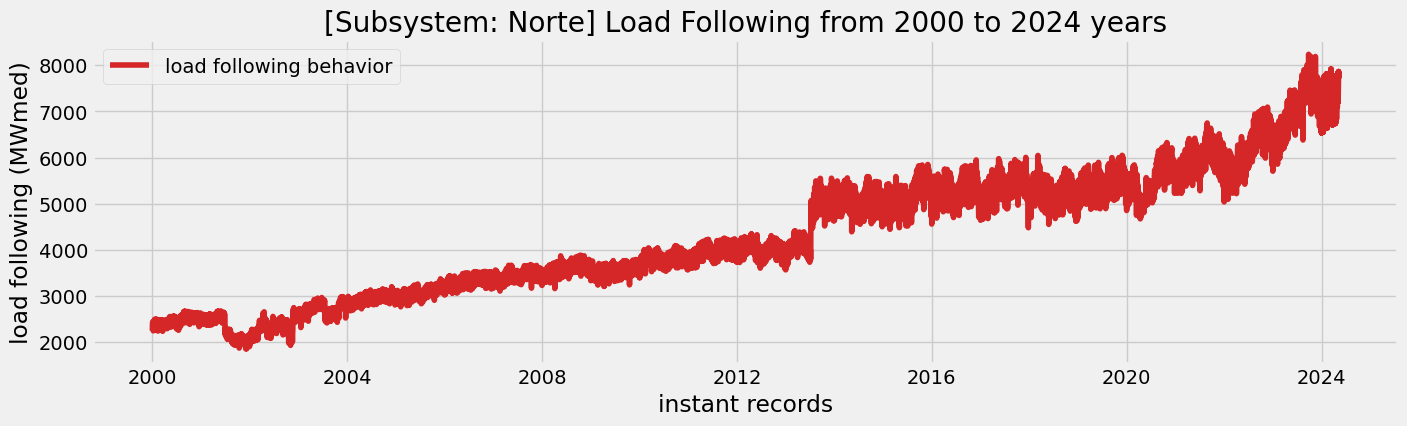

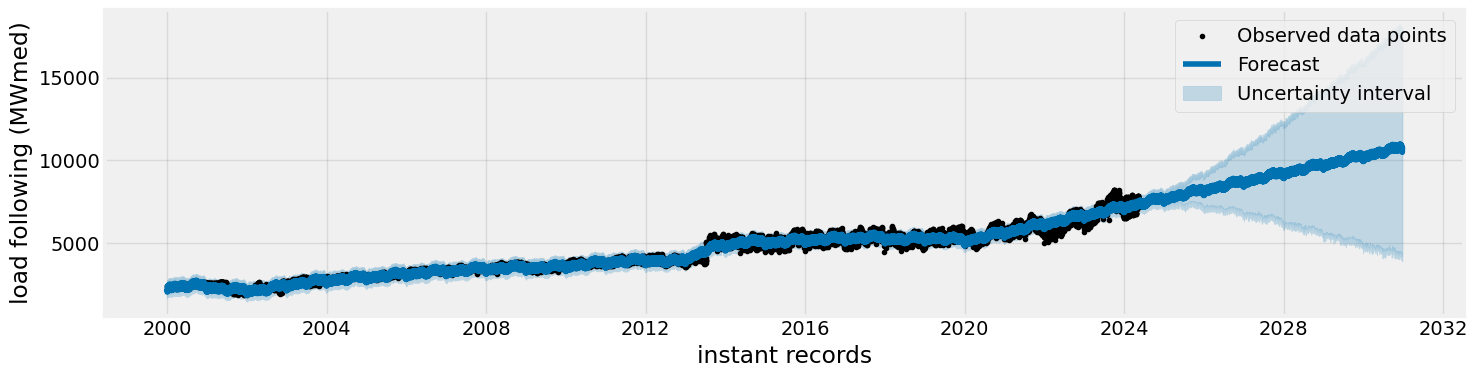

In [53]:
xlabel: str = "instant records"
ylabel: str = "load following (MWmed)"

plt.figure(figsize=(15,4), dpi=100)
plt.plot(df['instant_record'], df['instant_load_following'], color='tab:red', label='load following behavior')
plt.gca().set(
    title=f'[Subsystem: {SUBSYSTEM_NAME}] Load Following from {all_years[0]} to {all_years[-1]} years',
    xlabel=xlabel,
    ylabel=ylabel
)
plt.legend()

# plot_components in python fbprophet returns duplicate plots
# https://stackoverflow.com/a/54396283
forecasting_model.plot(
    forecast,
    uncertainty=True,
    figsize=(15,4),
    xlabel=xlabel,
    ylabel=ylabel,
    include_legend=True
);

plt.tight_layout()
plt.show()

In [54]:
stripped_forecast: pd.DataFrame = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
stripped_forecast.head()

,ds,yhat,yhat_lower,yhat_upper
0,2000-01-01,2233.389305,1857.577052,2638.832335
1,2000-01-02,2052.225957,1698.585232,2462.536159
2,2000-01-03,2366.554318,1963.654303,2746.020905
3,2000-01-04,2399.938904,1997.223148,2809.944409
4,2000-01-05,2412.614607,2026.480971,2777.781094


In [79]:
print(stripped_forecast[stripped_forecast['ds'] == '2000-01-01']['yhat'][0])

2233.38930490784


In [91]:
test_df: pd.DataFrame = stripped_forecast[
    (stripped_forecast['ds'] >= '2000-01-01') &\
    (stripped_forecast['ds'] <= '2000-01-10')
]

In [97]:
print(test_df)

          ds         yhat   yhat_lower   yhat_upper
0 2000-01-01  2233.389305  1857.577052  2638.832335
1 2000-01-02  2052.225957  1698.585232  2462.536159
2 2000-01-03  2366.554318  1963.654303  2746.020905
3 2000-01-04  2399.938904  1997.223148  2809.944409
4 2000-01-05  2412.614607  2026.480971  2777.781094
5 2000-01-06  2414.243484  2035.798817  2793.808551
6 2000-01-07  2406.365511  2007.793456  2803.774778
7 2000-01-08  2260.403011  1853.722312  2649.901620
8 2000-01-09  2085.690897  1730.212751  2506.366410
9 2000-01-10  2405.656422  1992.542254  2793.955551


In [178]:
for ds, yhat in [(i[0], i[1]) for i in test_df.itertuples(False)]:
    print(ds, yhat)

2000-01-01 00:00:00 2233.38930490784
2000-01-02 00:00:00 2052.22595730111
2000-01-03 00:00:00 2366.5543180821837
2000-01-04 00:00:00 2399.9389040528363
2000-01-05 00:00:00 2412.6146068411667
2000-01-06 00:00:00 2414.2434842404346
2000-01-07 00:00:00 2406.365510883566
2000-01-08 00:00:00 2260.4030113433055
2000-01-09 00:00:00 2085.6908965974217
2000-01-10 00:00:00 2405.656421965206


In [57]:
formatted_df.head()

,ds,y
0,2000-01-01,2243.51
1,2000-01-02,2259.81
2,2000-01-03,2407.43
3,2000-01-04,2404.22
4,2000-01-05,2439.65


In [59]:
%time forecast_cv: pd.DataFrame = cross_validation(forecasting_model, horizon='365 days', parallel='threads')
forecast_performance: pd.DataFrame = performance_metrics(forecast_cv)

2024-05-14 18:46:17,69  - INFO     => Making 41 forecasts with cutoffs between 2003-05-14 00:00:00 and 2023-05-09 00:00:00
2024-05-14 18:46:17,71  - INFO     => Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x0000025E12E34590>
2024-05-14 18:46:17,75  - DEBUG    => cmd: where.exe tbb.dll
cwd: None
2024-05-14 18:46:17,77  - DEBUG    => cmd: where.exe tbb.dll
cwd: None
2024-05-14 18:46:17,78  - DEBUG    => cmd: where.exe tbb.dll
cwd: None
2024-05-14 18:46:17,79  - DEBUG    => cmd: where.exe tbb.dll
cwd: None
2024-05-14 18:46:17,79  - DEBUG    => cmd: where.exe tbb.dll
cwd: None
2024-05-14 18:46:17,80  - DEBUG    => cmd: where.exe tbb.dll
cwd: None
2024-05-14 18:46:17,81  - DEBUG    => cmd: where.exe tbb.dll
cwd: None
2024-05-14 18:46:17,85  - DEBUG    => cmd: where.exe tbb.dll
cwd: None
2024-05-14 18:46:17,85  - DEBUG    => cmd: where.exe tbb.dll
cwd: None
2024-05-14 18:46:17,86  - DEBUG    => cmd: where.exe tbb.dll
cwd: None
2024-05-14 18:46:17,87  - D

CPU times: total: 1min 11s
Wall time: 2min 50s


In [61]:
forecast_performance.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days 12:00:00,67031.178065,258.903801,183.950542,0.036898,0.027749,0.037124,0.747041
1,38 days 00:00:00,66745.311847,258.351141,183.469497,0.036807,0.027749,0.037026,0.747566
2,38 days 12:00:00,67093.220024,259.023590,183.943209,0.036895,0.027911,0.037110,0.747041
3,39 days 00:00:00,66891.413173,258.633743,183.791713,0.036875,0.027978,0.037079,0.746595
4,39 days 12:00:00,66964.119865,258.774264,183.847344,0.036905,0.028146,0.037102,0.745891


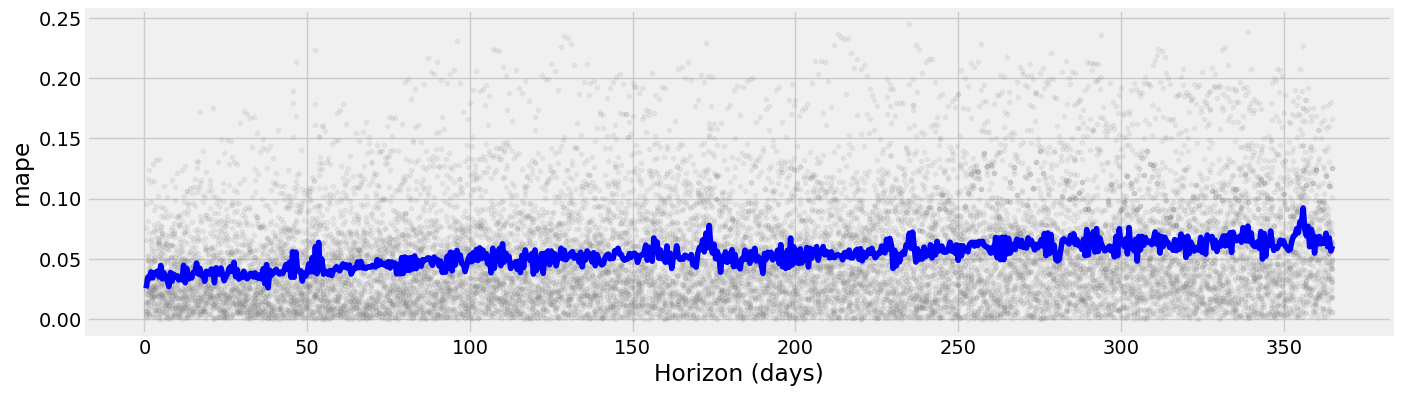

In [62]:
plot_cross_validation_metric(forecast_cv, metric='mape', rolling_window=0, figsize=(15,4));

In [65]:
prediction_accuracy_using_mape: float = 1 - forecast_performance['mape'].mean()
print(f'Prediction model accuracy using MAPE metric: {prediction_accuracy_using_mape:0.6%}')

Prediction model accuracy using MAPE metric: 94.703981%


In [184]:
start_dt: datetime = datetime.now()
final_dt: datetime = start_dt + timedelta(days=30)

In [188]:
difference_dt: timedelta = final_dt - start_dt

In [244]:
print(f'from: {start_dt}\t', f'to: {final_dt}')

start_dt_str: str = start_dt.strftime('%Y-%m-%d')
final_dt_str: str = final_dt.strftime('%Y-%m-%d')

filtered_df: pd.DataFrame = stripped_forecast.loc[stripped_forecast['ds'] > start_dt_str]

#for i in range(1, difference_dt.days + 1):
#    data = stripped_forecast.loc[stripped_forecast['ds'].dt.to_pytimedelta() == start_dt + timedelta(days=i)]
#    print(len(data['yhat']), data['yhat'])

from: 2024-05-12 18:23:20.951731	 to: 2024-06-11 18:23:20.951731


In [246]:
print(len(filtered_df))

2419
